In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datetime as dt
import pandas as pd
import math
import scipy
import requests
import h5py
import fsspec
from pyproj import Proj, CRS
import pysolid
import pymap3d as pm   #for transformation between ENU and llh
import time
import matplotlib.pyplot as plt
from isce3.core import Ellipsoid as ellips
from osgeo import gdal, osr
import shapely.wkt as wkt
from shapely import geometry
import os
import timeit
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import sys
sys.path.append('../')
from src.ALE_utils import stream_cslc, stream_static_layers, oversample_slc, get_snr_peak, findCR, en2rdr

import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_s3path(data_dir, burst_id):
    cslc_urls = []
    buckt = data_dir.split("/")[2]
    prefx = f'{data_dir.split("/")[3]}/{data_dir.split("/")[4]}/OPERA_L2_CSLC-S1A_IW_{burst_id.upper()}_VV_'
    client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    result = client.list_objects(Bucket=buckt, Prefix=prefx, Delimiter = '/')
    for o in result.get('CommonPrefixes'):
        path = o.get('Prefix')
        ver = (path.split('/')[2].split('_')[7])    
        if path[-14:-1]!='static_layers' and ver=='v0.1':
            cslc_url = (f's3://{buckt}/{path}{path.split("/")[-2]}.h5')
            cslc_urls.append(cslc_url)
        elif path[-14:-1]=='static_layers' and ver=='v0.1':
            cslc_static_url = (f's3://{buckt}/{path}{path.split("/")[-2]}.h5')

    return cslc_urls, cslc_static_url

In [4]:
data_dir = 's3://opera-pst-rs-pop1/products/CSLC_S1'
burst_id = 't064-135523-iw2'#'t137-292331-iw1'
date = '20230618'

#'t042-088925-iw1'

In [5]:
cslc_urls = []; cslc_static_urls = [];
cslc_urls, cslc_static_url  = get_s3path(data_dir, burst_id)

In [6]:
cslc_urls

['s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1A_IW_T064-135523-IW2_VV_20141221T015007Z_v0.1_20230707T220352Z/OPERA_L2_CSLC-S1A_IW_T064-135523-IW2_VV_20141221T015007Z_v0.1_20230707T220352Z.h5',
 's3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1A_IW_T064-135523-IW2_VV_20150114T015006Z_v0.1_20230707T220418Z/OPERA_L2_CSLC-S1A_IW_T064-135523-IW2_VV_20150114T015006Z_v0.1_20230707T220418Z.h5',
 's3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1A_IW_T064-135523-IW2_VV_20150207T015005Z_v0.1_20230707T231509Z/OPERA_L2_CSLC-S1A_IW_T064-135523-IW2_VV_20150207T015005Z_v0.1_20230707T231509Z.h5',
 's3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1A_IW_T064-135523-IW2_VV_20150327T015006Z_v0.1_20230707T221611Z/OPERA_L2_CSLC-S1A_IW_T064-135523-IW2_VV_20150327T015006Z_v0.1_20230707T221611Z.h5',
 's3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1A_IW_T064-135523-IW2_VV_20150502T015007Z_v0.1_20230707T220204Z/OPERA_L2_CSLC-S1A_IW_T064-135523-IW2_VV_20150502T015007Z_v0

In [7]:
cslc_url = cslc_urls[-1]

pol = cslc_url.split('/')[6].split('_')[5]
s3f = fsspec.open(cslc_url, mode='rb', anon=True, default_fill_cache=False)

# Stream the data
cslc,azimuth_carrier_phase,flattening_phase,xcoor,ycoor,dx,dy,epsg,sensing_start,sensing_stop,dims,bounding_polygon,orbit_direction,center_lon,center_lat,wavelength = stream_cslc(s3f,pol)

In [8]:
# Get bounding box
cslc_poly = wkt.loads(bounding_polygon)

# Deramp the cslc
ramp = np.exp(1j*azimuth_carrier_phase)
cslc = cslc*np.conj(ramp)

# Unflatten the cslc
flat_phase = np.exp(1j*flattening_phase)
cslc = cslc*np.conj(flat_phase) 

# # Deramp the cslc
# ramp = np.exp(1j*azimuth_carrier_phase)
# deramped_cslc = cslc*np.conj(ramp)

# # Unflatten the cslc
# flat_phase = np.exp(1j*flattening_phase)
# unflattened_cslc = cslc*np.conj(flat_phase)

# deramped_unflattened_cslc = cslc*np.conj(ramp)*np.conj(flat_phase)

In [9]:
# Get the cslc date
# Read to pandas dataframe and rename columns
df = pd.read_csv('../validation_data/opera_crdata.csv')
df.rename(columns={'Corner reflector ID':'ID'}, inplace=True)
df.rename(columns={'Latitude (deg)':'lat'}, inplace=True) 
df.rename(columns={'Longitude (deg)':'lon'}, inplace=True) 
df.rename(columns={'Azimuth (deg)':'azm'}, inplace=True)
df.rename(columns={'Tilt / Elevation angle (deg)':'tilt'}, inplace=True)
df.rename(columns={'Height above ellipsoid (m)':'hgt'}, inplace=True) 
df.rename(columns={'Side length (m)':'slen'}, inplace=True)

df.head()

,ID,lat,lon,hgt,azm,tilt,slen
0,OPERA_CR1,36.140443,-120.879208,779.755,0,15.5,2.4
1,OPERA_CR2,36.140424,-120.879167,779.755,180,14.8,2.4
2,OPERA_CR3,36.187509,-120.758987,779.755,1,13.5,2.4
3,OPERA_CR4,36.187090,-120.758347,788.546,181,15.8,2.4


In [16]:
pwd

'/u/trappist-r0/bato/tools/calval-CSLC/util_notebooks'

In [18]:
# # Get the cslc date and time
# date_ = dt.datetime.strptime(sensing_start.astype(str),'%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d+%H\u0021%M')
# crfile = f'./crdata_{burst_id.upper()}_{date}.csv'

# if os.path.isfile(crfile) == False and cr_network=='Rosamond':
#     # Download corner reflector data from UAVSAR/NISAR based on the date of the CSLC product
#     res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=uavsar')
#     # Write to file
#     with open(crfile, 'wb') as f:
#         f.write(res.content)

# elif os.path.isfile(crfile) == False and cr_network=='Oklahoma':
#     # Download corner reflector data from UAVSAR/NISAR based on the date of the CSLC product
#     res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=nisar')
#     # Write to file
#     with open(crfile, 'wb') as f:
#         f.write(res.content)

# elif os.path.isfile(crfile) == False and cr_network=='Alaska':
#     # Download corner reflector data from NISAR based on the date of the CSLC product
#     res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=alaska')
#     # Write to file
#     with open(crfile, 'wb') as f:
#         f.write(res.content)

# else:
#     print(f'Corner Reflector Data: crdata_{date}.csv already exists. Skipping download.')

# time.sleep(2)
# # Read to pandas dataframe and rename columns
# df = pd.read_csv(crfile)
# df.rename(columns={'Corner reflector ID':'ID'}, inplace=True)
# df.rename(columns={'Latitude (deg)':'lat'}, inplace=True) 
# df.rename(columns={'Longitude (deg)':'lon'}, inplace=True) 
# df.rename(columns={'Azimuth (deg)':'azm'}, inplace=True)
# df.rename(columns={'Tilt / Elevation angle (deg)':'tilt'}, inplace=True)
# df.rename(columns={'Height above ellipsoid (m)':'hgt'}, inplace=True) 
# df.rename(columns={'Side length (m)':'slen'}, inplace=True)
# df.slen = np.round(df.slen,1)
# df

Corner Reflector Data: crdata_20230618.csv already exists. Skipping download.


FileNotFoundError: [Errno 2] No such file or directory: './crdata_T064-135523-IW2_20230618.csv'

In [10]:
if 'lon' not in df.keys():
    raise SystemExit('No CRs found within burst, exit notebook')

In [11]:
# Parameters for papermill
snr_threshold = 15
solidtide = 'False'
cr_network = 'SAF'
ovsFactor = 128

In [12]:
#calculating the locations of CRs in SAR image
UTMx = []
UTMy = []
xloc = []
yloc = []
xloc_float = []
yloc_float = []
_in = []

for idx, row in df.iterrows():
    
    _Proj = Proj(CRS.from_epsg(epsg))
    _x, _y = _Proj(row['lon'], row['lat'],inverse=False)     #conversion of lat/lon of CRs to UTM coordinates
    
    #location of CRs in SLC image
    _xloc = int((_x-xcoor[0])/dx)    
    _yloc = int((_y-ycoor[0])/dy)
    
    UTMx.append(_x) 
    UTMy.append(_y)
    xloc.append(_xloc)
    yloc.append(_yloc)
    xloc_float.append((_x-xcoor[0])/dx)
    yloc_float.append((_y-ycoor[0])/dy)
    _in.append(cslc_poly.contains(geometry.Point(row['lon'], row['lat'])))
    
df['UTMx'] = UTMx
df['UTMy'] = UTMy
df['xloc'] = xloc
df['yloc'] = yloc
df['xloc_float'] = xloc_float
df['yloc_float'] = yloc_float
df['inPoly'] = _in

#checking whether CRs are in SLC coverage. Including only CRs within SLC image
df = df[df['inPoly']==True]
df.drop('inPoly', axis=1, inplace=True)
df = df.reset_index(drop=True)
df.head()

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float


In [13]:
# selecting CRs according to orbit direction
if orbit_direction == 'Ascending':
    df_filter = df[(df['azm']>-15) & (df['azm']<15)].reset_index(drop=True)
    #only west-looking CRs (for right-looking ascending)
else:     #Descending
    df_filter = df[((df['azm']>170) & (df['azm']<190))].reset_index(drop=True)
    #only east-looking CRs (for right-looking descending)

df_filter = df_filter.loc[df_filter['slen']>0.8].reset_index(drop=True)   #excluding SWOT CRs (0.7 m as a side length)
df = None

ValueError: Axis limits cannot be NaN or Inf

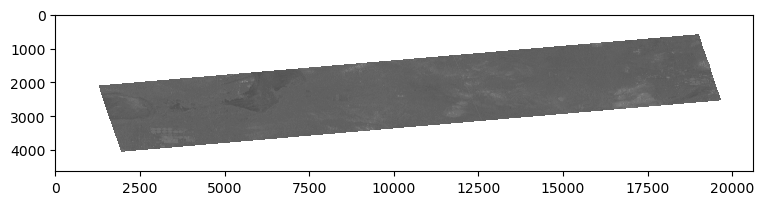

In [14]:
#Displaying SLC image
buffer = 50
minX = df_filter['xloc'].min() - buffer
maxX = df_filter['xloc'].max() + buffer
minY = df_filter['yloc'].min() - buffer
maxY = df_filter['yloc'].max() + buffer

scale_ = 1.0
exp_ = 0.15

fig, ax = plt.subplots(figsize=(9, 9))
cax=ax.imshow(scale_*(np.abs(cslc))**exp_, cmap='gray',interpolation=None, origin='upper')
ax.set_xlim(minX,maxX)
ax.set_ylim(minY,maxY)

for sl in pd.unique(df_filter.slen):
    xx = df_filter.loc[df_filter['slen']==sl]['xloc']
    yy = df_filter.loc[df_filter['slen']==sl]['yloc']
    ID = df_filter.loc[df_filter['slen']==sl]['ID']
    
    if sl == 2.4:
        color='blue'
    elif sl == 4.8:
        color='red'
    elif sl == 2.8:
        color='yellow'
    else:
        color='green'
    
    ax.scatter(xx,yy,color=color,marker="+",lw=2)
    for _ID,_xx,_yy in zip(ID,xx,yy):
        ax.annotate(_ID, (_xx, _yy), fontsize=12)

ax.set_aspect(1)
#fig.savefig('S1_CSLC_CRs_'+orbit_direction+'.png',dpi=300,bbox_inches='tight')

In [ ]:
xpeak = []
ypeak = []
snr = []

for ID, xoff, yoff in zip(df_filter['ID'],df_filter['xloc'],df_filter['yloc']):
    # crop a patch of 10*10 with center at the calculated CR position
    pxbuff = 5
    pybuff = 5
    cropcslc = cslc[(yoff-pybuff):(yoff+pybuff),(xoff-pxbuff):(xoff+pxbuff)]
    _snr = get_snr_peak(cropcslc)

    # find the peak amplitude in the 10*10 patch
    yind,xind = np.unravel_index(np.argmax(np.abs(cropcslc), axis=None), cropcslc.shape)
    
    # give a warning if the peak and the calculated postion are too far
    dyind = yind-pybuff; dxind = xind-pxbuff
    dist = math.sqrt(dyind**2+dxind**2)
    if dist > 5.0:
        warnings.warn(f'the most bright pixel and the xloc is too far for CR {ID}')
    
    # crop a patch of 32*32 but with its center at the peak
    xbuff = 32
    ybuff = 32
    ycrop = np.arange(yoff+dyind-ybuff,yoff+dyind+ybuff)
    xcrop = np.arange(xoff+dxind-xbuff,xoff+dxind+xbuff)
    cropcslc = cslc[ycrop,:][:,xcrop]

    cslc_crop_oversampled = oversample_slc(cropcslc,sampling=15)[0]
    amplitude = 20*np.log10(np.abs(cslc_crop_oversampled))
    fig, ax = plt.subplots()
    cax=ax.imshow(20*np.log10(np.abs(cslc_crop_oversampled)), cmap='gray',interpolation=None, origin='upper', vmin=np.mean(amplitude)-2*np.std(amplitude), vmax=np.mean(amplitude)+2*np.std(amplitude))
    xpk = int(xoff - (xoff+dxind-xbuff)) * 15; ypk = int(yoff - (yoff+dyind-ybuff)) * 15
    ax.plot(ypk,xpk, marker="^", color='r')
    ax.set_aspect(1)
    cbar = fig.colorbar(cax)
    cbar.set_label('Amplitude')
    ax.set_title(f'{ID} ({burst_id}_{date})')

    # Oversample slc
    cropcslc_ovs,ycrop_ovs,xcrop_ovs = oversample_slc(cropcslc,sampling=ovsFactor,y=ycrop,x=xcrop)

    if _snr > snr_threshold:
        fig, ax = plt.subplots(figsize=(9, 6))
        cax=ax.imshow(20*np.log10(np.abs(cropcslc_ovs)), cmap='gray',interpolation=None,
                    extent=(xoff+dxind-xbuff,xoff+dxind+xbuff+1,yoff+dyind+ybuff+1,yoff+dyind-ybuff),origin='upper',vmin=0,vmax=100)
        fig.colorbar(cax)
        fig.suptitle(f'CR{ID}_{burst_id}_{date}')
        ax.set_aspect(1)


    # find the peak amplitude again in a 2 x 2 patch, it correspond to 
    # (2*ovsFactor) x (2*ovsFactor) in oversampled slc
    yoff2 = int(cropcslc_ovs.shape[0]/2)
    xoff2 = int(cropcslc_ovs.shape[1]/2)
    cropcslc2 = cropcslc_ovs[yoff2-ovsFactor:yoff2+ovsFactor+1,
                           xoff2-ovsFactor:xoff2+ovsFactor+1]
    yind2,xind2 = np.unravel_index(np.argmax(abs(cropcslc2), axis=None), cropcslc2.shape)
    dyind2 = yind2-ovsFactor; dxind2 = xind2-ovsFactor
    
    # crop a patch of 3x3 oversampled patch with center at the peak
    cropcslc2 = cropcslc_ovs[yoff2+dyind2-1:yoff2+dyind2+2,xoff2+dxind2-1:xoff2+dxind2+2]
    ycrop2 = ycrop_ovs[yoff2+dyind2-1:yoff2+dyind2+2]
    xcrop2 = xcrop_ovs[xoff2+dxind2-1:xoff2+dxind2+2]
    xxcrop2,yycrop2 = np.meshgrid(xcrop2,ycrop2)
    xxcrop2_f = xxcrop2.flatten()
    yycrop2_f = yycrop2.flatten()
    cropcslc2_f = cropcslc2.flatten()

    # Check if pixel values in a patch are non-NaN
    valid = ~(np.isnan(cropcslc2_f))
    count_valid = np.count_nonzero(valid)

    if count_valid == 0:
        _ypeak, _xpeak = [np.nan, np.nan]

    else:
        _ypeak,_xpeak = findCR(np.abs(cropcslc2_f[valid]),yycrop2_f[valid],xxcrop2_f[valid],
                            x_bound=[xcrop2[0],xcrop2[-1]],y_bound=[ycrop2[0],ycrop2[-1]],method="para")

    xpeak.append(_xpeak)
    ypeak.append(_ypeak)
    snr.append(_snr)

    # Get observed RCS and then plot
    I_dB = 10*np.log10(cropcslc.real**2 + cropcslc.imag**2)
    if ~np.isnan(_ypeak) | ~np.isnan(_xpeak):
        ypk = int(np.round(_ypeak)) -( yoff+dyind-ybuff); xpk = int(np.round(_xpeak)) - (xoff+dxind-xbuff)
        plt.figure(); plt.imshow(I_dB,cmap='gray',interpolation=None, origin='upper'); plt.plot(ypk,xpk, marker='+', color='b'); plt.title(f'ID:{ID}, y:{ypk-(yoff+dyind-ybuff)} x:{xpk-(xoff+dxind-xbuff)}')

df_filter['xloc_CR'] = xpeak
df_filter['yloc_CR'] = ypeak
df_filter['snr'] = snr
df_filter